In [5]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import Bargaining as brg

import numpy as np
import numba as nb
import scipy.optimize as optimize
import copy

from EconModel import EconModelClass
from consav.grids import nonlinspace
from consav import linear_interp, linear_interp_1d
from consav import quadrature

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

# c++ settings
do_cpp = True
do_compile = True
threads = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [6]:
# compile c++ files
if do_cpp & do_compile:
    model = brg.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)

In [7]:
# settings for models to solve
T = 10
specs = {
    'model 1':{'latexname':'$\sigma_{\psi}=0$', 'par':{'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads}},
    # 'model 2':{'latexname':'$\sigma_{\psi}=0.04$', 'par':{'sigma_love':0.04,'T':T,'do_cpp':do_cpp,'threads':threads}},
    # 'model 3':{'latexname':'$\sigma_{\psi}=0.1$', 'par':{'sigma_love':0.1,'T':T,'do_cpp':do_cpp,'threads':threads}},
    # 'model 4':{'latexname':'$\kappa_w=0.3$', 'par':{'div_A_share':0.3,'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads}},
}


In [8]:
# solve different models
models = {}
for name,spec in specs.items():
    print(f'solving {name}...')
    
    # setup model
    models[name] = brg.HouseholdModelClass(name=name,par=spec['par'])
    if do_cpp: models[name].link_to_cpp(force_compile=False)
    models[name].spec = spec
    
    # solve
    models[name].solve()

solving model 1...


In [9]:
model = models['model 1']
sol = model.sol
par = model.par

In [10]:
# Set index
t=9
iP=10
iL=20
iA=10
idx_couple = lambda iP: (t,iP,iL,iA)
idx_single = (t,iA)

# Unpack lists
remain_Vw = sol.Vw_remain_couple[t,:,iL,iA]
remain_Vm = sol.Vm_remain_couple[t,:,iL,iA]
remain_Cw_priv = sol.Cw_priv_remain_couple[t,:,iL,iA]
remain_Cm_priv = sol.Cm_priv_remain_couple[t,:,iL,iA]
remain_C_pub = sol.C_pub_remain_couple[t,:,iL,iA]

list_couple = copy.deepcopy((sol.Vw_couple,sol.Vm_couple,sol.Cw_priv_couple,sol.Cm_priv_couple,sol.C_pub_couple))
list_raw = copy.deepcopy((remain_Vw,remain_Vm,remain_Cw_priv,remain_Cm_priv,remain_C_pub))
list_single = copy.deepcopy((sol.Vw_single,sol.Vm_single,sol.Cw_priv_single,sol.Cm_priv_single,sol.Cw_pub_single)) # last input here not important in case of divorce

# Get power variables
power_idx = copy.deepcopy(sol.power_idx)
power = copy.deepcopy(sol.power)

# Calculate surplus
Sw = sol.Vw_remain_couple[t,:,iL,iA]-sol.Vw_single[idx_single]
Sm = sol.Vm_remain_couple[t,:,iL,iA]-sol.Vm_single[idx_single]

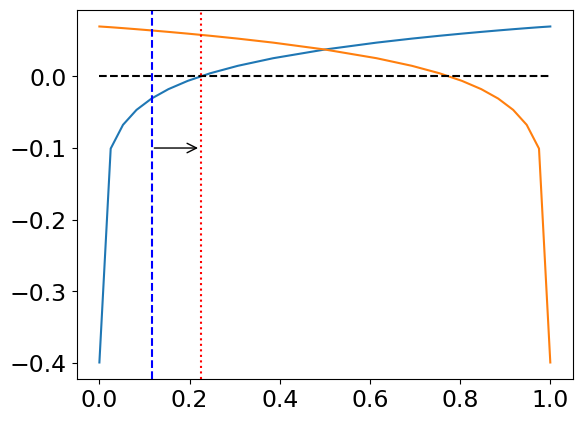

In [34]:
def plot_surplus(par, Sw, Sm, start_power_idx, index_couple, power):
    plt.plot(par.grid_power,Sw)
    plt.plot(par.grid_power,Sm)
    plt.plot(par.grid_power,np.zeros(par.num_power), color=
            'black',linestyle='--')
    #add vertical line at start_power
    start_power = par.grid_power[start_power_idx]
    plt.axvline(x=start_power, color='blue',linestyle='--')

    #add vertical line at end_power if it exists
    end_power = power[index_couple(start_power_idx)]
    if end_power > 0:
        plt.axvline(x=end_power, color='red',linestyle=':')

        # make a one directional arrow from start_power to end_power lower than the x axis
        plt.annotate("", xy=(end_power, -0.1), xytext=(start_power, -0.1), arrowprops=dict(arrowstyle="->"))
    

plot_surplus(par, Sw, Sm, 4, idx_couple, power)

In [12]:
def check_participation_constraints_old(power_idx,power,Sw,Sm,idx_single,idx_couple,list_couple,list_raw,list_single, par):
    
    # check the participation constraints. Array
    min_Sw = np.min(Sw)
    min_Sm = np.min(Sm)
    max_Sw = np.max(Sw)
    max_Sm = np.max(Sm)

    if (min_Sw >= 0.0) & (min_Sm >= 0.0): # all values are consistent with marriage
        for iP in range(par.num_power):

            # overwrite output for couple
            idx = idx_couple(iP)
            for i,key in enumerate(list_couple):
                list_couple[i][idx] = list_raw[i][iP]

            power_idx[idx] = iP
            power[idx] = par.grid_power[iP]

    elif (max_Sw < 0.0) | (max_Sm < 0.0): # no value is consistent with marriage
        for iP in range(par.num_power):

            # overwrite output for couple
            idx = idx_couple(iP)
            for i,key in enumerate(list_couple):
                list_couple[i][idx] = list_single[i][idx_single]

            power_idx[idx] = -1
            power[idx] = -1.0

    else: 
    
        # find lowest (highest) value with positive surplus for women (men)
        Low_w = 1 #0 # in case there is no crossing, this will be the correct value
        Low_m = par.num_power-1-1 #par.num_power-1 # in case there is no crossing, this will be the correct value
        for iP in range(par.num_power-1):
            if (Sw[iP]<0) & (Sw[iP+1]>=0):
                Low_w = iP+1                # first node where she has positive surplus
                
            if (Sm[iP]>=0) & (Sm[iP+1]<0):
                Low_m = iP                  # last node where he has positive surplus


        # b. interpolate the surplus of each member at indifference points
        # women indifference
        id = Low_w-1        # last node where she hase negative surplus
        denom = (par.grid_power[id+1] - par.grid_power[id])
        ratio_w = (Sw[id+1] - Sw[id])/denom
        ratio_m = (Sm[id+1] - Sm[id])/denom
        power_at_zero_w = par.grid_power[id] - Sw[id]/ratio_w  # interpolated power at indifference point
        Sm_at_zero_w = Sm[id] + ratio_m*( power_at_zero_w - par.grid_power[id] ) # man's surplus at woman's indifference point

        # men indifference
        id = Low_m
        denom = (par.grid_power[id+1] - par.grid_power[id])
        ratio_w = (Sw[id+1] - Sw[id])/denom
        ratio_m = (Sm[id+1] - Sm[id])/denom
        power_at_zero_m = par.grid_power[id] - Sm[id]/ratio_m  # interpolated power at indifference point
        Sw_at_zero_m = Sw[id] + ratio_w*( power_at_zero_m - par.grid_power[id] ) # woman's surplus at man's indifference point


        # update the outcomes
        for iP in range(par.num_power):

            # index to store solution for couple 
            idx = idx_couple(iP)
    
            # woman wants to leave
            if iP<Low_w: 
                if Sm_at_zero_w > 0: # man happy to shift some bargaining power

                    for i,key in enumerate(list_couple):
                        if iP==0:
                            list_couple[i][idx] = linear_interp_1d._interp_1d(par.grid_power,list_raw[i],power_at_zero_w,Low_w-1) # list_raw is remain_as_couple
                                                    # _interp_1d is second step of interpolation when location in grid has been found -> speedy
                        else:
                            list_couple[i][idx] = list_couple[i][idx_couple(0)]; # re-use that the interpolated values are identical
                                                    # any bargaining point lower than Low_w will result in same outcome

                    power_idx[idx] = Low_w
                    power[idx] = power_at_zero_w
                    
                else: # divorce

                    for i,key in enumerate(list_couple):
                        list_couple[i][idx] = list_single[i][idx_single]

                    power_idx[idx] = -1
                    power[idx] = -1.0
                
            # man wants to leave
            elif iP>Low_m: 
                if Sw_at_zero_m > 0: # woman happy to shift some bargaining power
                    
                    for i,key in enumerate(list_couple):
                        if (iP==(Low_m+1)):
                            list_couple[i][idx] = linear_interp_1d._interp_1d(par.grid_power,list_raw[i],power_at_zero_m,Low_m) 
                        else:
                            list_couple[i][idx] = list_couple[i][idx_couple(Low_m+1)]; # re-use that the interpolated values are identical

                    power_idx[idx] = Low_m
                    power[idx] = power_at_zero_m
                    
                else: # divorce

                    for i,key in enumerate(list_couple):
                        list_couple[i][idx] = list_single[i][idx_single]

                    power_idx[idx] = -1
                    power[idx] = -1.0

            else: # no-one wants to leave

                for i,key in enumerate(list_couple):
                    list_couple[i][idx] = list_raw[i][iP]

                power_idx[idx] = iP
                power[idx] = par.grid_power[iP]

In [13]:
#check_participation_constraints_old(power_idx,power,Sw,Sm,idx_single,idx_couple,list_couple,list_raw,list_single, par)

In [14]:
def divorce(power_idx, power,idx_single,idx_couple, list_start_as_couple,list_trans_to_single, par):
    for iP in range(par.num_power):
        # overwrite output for couple
        idx = idx_couple(iP)
        for i,key in enumerate(list_start_as_couple):
            list_start_as_couple[i][idx] = list_trans_to_single[i][idx_single]

        power_idx[idx] = -1
        power[idx] = -1.0

In [15]:
# make a function that finds the indifference point and the index given a grid over surplus
def find_indifference_point(S,par):

    assert S[0]*S[-1] < 0, 'no indifference point'

    for iP in range(par.num_power-1):
        if S[iP]*S[iP+1] < 0:
            # find the indifference point
            denom = (par.grid_power[iP+1] - par.grid_power[iP])
            ratio = (S[iP+1] - S[iP])/denom
            power_at_zero = par.grid_power[iP] - S[iP]/ratio  # interpolated power at indifference point
            return iP, power_at_zero # return point below indifference point and power at indifference point

In [16]:
find_indifference_point(Sw,par)

(6, 0.22498207097759637)

In [22]:
def check_participation_constraints(power_idx,power,Sw,Sm,idx_single,idx_couple,list_start_as_couple,list_remain_couple,list_trans_to_single, par):

    # make function for update_list_couple and divorce

    # step 1: check end points
    if (Sw[0] > 0.0) & (Sm[-1] > 0.0): # all values are consistent with marriage
        # overwrite output for couple
        for iP in range(par.num_power):
            idx = idx_couple(iP)
            for i,key in enumerate(list_start_as_couple):
                list_start_as_couple[i][idx] = list_remain_as_couple[i][iP]

            power_idx[idx] = iP
            power[idx] = par.grid_power[iP]

    elif (Sw[-1] < 0.0) | (Sm[0] < 0.0): # no value is consistent with marriage
        divorce(power_idx, power,idx_single,idx_couple, list_start_as_couple,list_trans_to_single, par)
    
    # step 2: find indifference points
    else:

        iPw, power_at_zero_w = find_indifference_point(Sw,par)
        Low_w=iPw+1

        Low_m, power_at_zero_m = find_indifference_point(Sm,par)

        # step 3: verify potential for bargaining
        if power_at_zero_w<=power_at_zero_m: # no divorce
            for iP in range(par.num_power): 
                # overwrite output for couple
                idx = idx_couple(iP)

                # update bargaining power
                if iP<Low_w:
                    power_idx[idx] = Low_w
                    power[idx] = power_at_zero_w
                elif iP>Low_m:
                    power_idx[idx] = Low_m
                    power[idx] = power_at_zero_m
                else:
                    power_idx[idx] = iP
                    power[idx] = par.grid_power[iP]



                for i,key in enumerate(list_start_as_couple):
                    if (iP==0): # update to woman's indifference point
                        list_start_as_couple[i][idx] = linear_interp_1d._interp_1d(par.grid_power,list_remain_couple[i],
                                                                                   power_at_zero_w,Low_w-1)
                    elif iP <= Low_w:
                        list_start_as_couple[i][idx]=list_start_as_couple[i][idx_couple(0)]
                    elif iP <= Low_m:
                        list_start_as_couple[i][idx] = linear_interp_1d._interp_1d(par.grid_power,list_remain_couple[i],
                                                                                   power_at_zero_m,Low_m)
                    else:
                        list_couple[i][idx] = list_couple[i][idx_couple(Low_m)]; # re-use that the interpolated values are identical

        else: # divorce
            divorce(power_idx, power,idx_single,idx_couple, list_start_as_couple,list_trans_to_single, par)


In [30]:
check_participation_constraints(power_idx,power,Sw,Sm,idx_single,idx_couple,list_couple,list_raw,list_single, par)

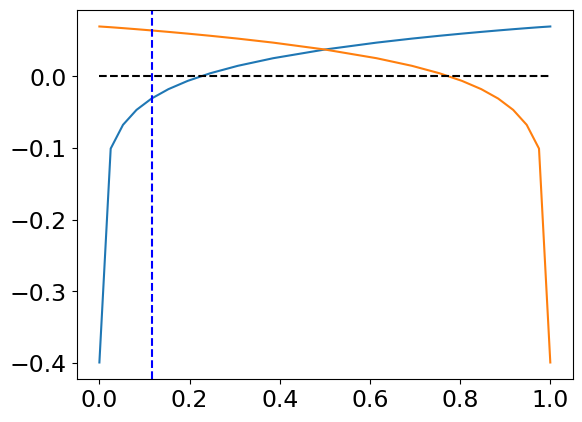

In [32]:
plot_surplus(par, Sw, Sm, 4, idx_couple, power)